# Files list preparation

In [1]:
import pickle

path = '/home/jovyan/RNAModif/rnamodif/2022_chr_split.pickle'
with open(path, 'rb') as handle:
    split_dict = pickle.load(handle)

pos_files_5eu = split_dict['5eu_2022_nia_chr1']
neg_files_5eu = split_dict['UNM_2022_nia_chr1']

print('5eu pos files (single read files)', len(pos_files_5eu))    
print('5eu neg files (single read files)', len(neg_files_5eu))    

# '5eu_nanoid_24h':'pos',
# '5eu_nanoid_neg':'neg',

5eu pos files (single read files) 73607
5eu neg files (single read files) 176093


In [3]:
from pathlib import Path
fiveEU_nanoid_path = Path('/home/jovyan/local_store/nanoid/20180516_1108_K562_5EU_1440_labeled_III_run')
pos_files_nanoid_24h = list(fiveEU_nanoid_path.rglob('*.fast5'))
fiveEU_nanoid_path_neg = Path('/home/jovyan/local_store/nanoid/20180403_1208_K562_5EU_0_unlabeled_III_run')
neg_files_nanoid = list(fiveEU_nanoid_path_neg.rglob('*.fast5'))

print('nanoid pos files (single read??? files)', len(pos_files_nanoid_24h))
print('nanoid neg files (single read??? files)', len(neg_files_nanoid))

nanoid pos files (single read??? files) 106173
nanoid neg files (single read??? files) 216906


In [4]:
NIA_POS = 'NIA_POS'
NIA_NEG = 'NIA_NEG'
NANOID_POS = 'NANOID_POS'
NANOID_NEG = 'NANOID_NEG'

exp_map = {
    NIA_POS:pos_files_5eu,
    NIA_NEG:neg_files_5eu,
    NANOID_POS:pos_files_nanoid_24h,
    NANOID_NEG:neg_files_nanoid,
}
exp_label = {
    NIA_POS:1,
    NIA_NEG:0,
    NANOID_POS:1,
    NANOID_NEG:0
}


# Data module

In [5]:
from torch.utils.data import IterableDataset
from rnamodif.data_utils.read_utils import process_read
from ont_fast5_api.fast5_interface import get_fast5_file

class ExhaustiveDataset(IterableDataset):
        def __init__(self, files, window, stride):
            self.files = files
            self.window = window
            self.stride = stride
            
        def process_files_fully(self, files, window):
            for fast5 in files: 
                try:
                    with get_fast5_file(fast5, mode='r') as f5:
                        for i, read in enumerate(f5.get_reads()):
                            x = process_read(read, window=None) 
                            #TODO trim start of the read?
                            for start in range(0, len(x), self.stride):
                                stop = start+window
                                if(stop >= len(x)):
                                    continue
                                identifier = {'file':str(fast5),
                                              'readid':read.read_id,
                                              'read_index_in_file':i,
                                              'start':start,
                                              'stop':stop,
                                             }
                                yield x[start:stop].reshape(-1,1).swapaxes(0,1), identifier  
                except OSError as error:
                    print(error)
                    continue

        def __iter__(self):
            return self.process_files_fully(self.files, self.window)
        
window = 4096
stride = window

dset_map = {k:ExhaustiveDataset(files = exp_map[k], window=window, stride=stride) for k,v in exp_map.items()}


In [6]:
for k,v in dset_map.items():
    print(k)
    print(len(v.files))

NIA_POS
73607
NIA_NEG
176093
NANOID_POS
106173
NANOID_NEG
216906


# Model loading


In [ ]:
# model = RodanPretrainedSeqcaller5eu()
# model

In [7]:
from rnamodif.architectures.rodan_seq_5eu import RodanPretrainedSeqcaller5eu
#Error = removed RELU, added batchnorm
checkpoint = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/5eu_2022_unfrozen_puregruhead/last.ckpt'
# checkpoint = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/nanoid2_frozen10_relufix/last.ckpt'
model = RodanPretrainedSeqcaller5eu().load_from_checkpoint(checkpoint)
# model

FREEZING 0 layers
FREEZING 0 layers


# Training

In [8]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl
preds_map = {}
for name, dataset in dset_map.items():
    print(name)
    #TODO utilize workers? Care for duplicate data!
    dataloader = DataLoader(dataset, batch_size=256)
    trainer = pl.Trainer(accelerator='gpu', precision=16)
    predictions = trainer.predict(model, dataloader)
    preds_map[name] = predictions
print('DONE')

NIA_POS


Using 16bit native Automatic Mixed Precision (AMP)
/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:93: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


NIA_NEG


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [9]:
import pickle
with open('5eu_2022_unfrozen_puregruhead_1kksteps.pickle', 'wb') as handle:
    pickle.dump(preds_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Metrics

In [10]:
with open(f'5eu_2022_unfrozen_puregruhead_1kksteps.pickle','rb') as f:
    preds_map = pickle.load(f)
for k,v in preds_map.items():
    print(k, len(v))

NIA_POS 3251
NIA_NEG 8802
NANOID_POS 4919
NANOID_NEG 18460


In [24]:
with open(f'5eu_frozen10_chrsplit_wide_epoch=0-step=18000.pickle','rb') as f:
    preds_map = pickle.load(f)
with open(f'5eu_frozen10_chrsplit_wide_epoch=0-step=1800_negs.pickle','rb') as f:
    preds_map_neg = pickle.load(f)   
    
for k,v in preds_map_neg.items():
    preds_map[k] = v
    
for k,v in preds_map.items():
    print(k, len(v))

NIA_POS 6214
NIA_NEG 16915
NANOID_POS 18156
NANOID_NEG 9028


In [11]:
from collections import defaultdict
import numpy as np
def predictions_to_read_predictions(predictions, label, exp, pooling='mean'):
    id_to_preds = defaultdict(list)
    for pr, ids in predictions:
        readid_probs = zip(ids['readid'], pr.numpy())
        for readid, probab in readid_probs:
            id_to_preds[readid].append(probab)
                
    if(pooling == 'max'):
        for k,v in id_to_preds.items():
            id_to_preds[k] = {'predicted':np.array(v).max(), 'label':label, 'exp':exp}
        return id_to_preds
    if(pooling == 'mean'):
        for k,v in id_to_preds.items():
            id_to_preds[k] = {'predicted':np.array(v).mean(), 'label':label, 'exp':exp}
        return id_to_preds
    if(pooling == 'none'):
        id_to_preds_nopool = {}
        for k,v in id_to_preds.items():
            for i,prob in enumerate(v):
                id_to_preds_nopool[f'{k}_{i}'] = {'predicted':prob, 'label':label, 'exp':exp}
        return id_to_preds_nopool
    
    else:
        raise Exception(f'{pooling} pooling not implemented')

In [22]:
# preds_map['NIA_POS'][0][1]

In [17]:
exp_readpred = {}
pooling = 'mean'
for exp in preds_map.keys():
    exp_readpred[exp] = predictions_to_read_predictions(preds_map[exp], label=exp_label[exp], exp=exp, pooling=pooling)

for k,v in exp_readpred.items():
    print(k, len(v))

NIA_POS 73542
NIA_NEG 175924
NANOID_POS 106173
NANOID_NEG 216905


In [13]:
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np

def plot_roc(read_preds_list, title=''):
    id_to_preds = {key: value for d in read_preds_list for key, value in d.items()}
    # id_to_preds = predictions_to_read_predictions(dsets_preds, pooling)
    labels = [v['label'] for k,v in id_to_preds.items()]
    predictions = [v['predicted'] for k,v in id_to_preds.items()]
    exps = np.unique([v['exp'] for k,v in id_to_preds.items()])
    
    if(np.isnan(predictions).any()):
        print('Warning: Nan found in predictions, setting to 0')
        print(np.where(np.isnan(predictions)))
        for nan_idx in np.where(np.isnan(predictions))[0]:
            predictions[nan_idx] = 0.0
    
    fpr, tpr, thresholds = metrics.roc_curve(labels, predictions)
    cutoff_1 = thresholds[np.argmax(tpr-fpr)]
    cutoff_1_tpr = tpr[np.argmax(tpr-fpr)]
    
    cutoff_2 = thresholds[np.argmin((1-tpr) ** 2 + fpr ** 2)]
    cutoff_2_tpr = tpr[np.argmin((1-tpr) ** 2 + fpr ** 2)]
    
    try:
        auc = metrics.roc_auc_score(labels, predictions)
        precision, recall, thresholds = metrics.precision_recall_curve(labels, predictions)
    except ValueError:
        print('AUC not defined')
        auc=0
    
    exps = str(exps[:len(exps)//2])+'\n'+str(exps[len(exps)//2:]) #For nice legend printing
    plt.plot(fpr, tpr, label = f'{exps} \n AUC %.3f CUTOFFS {str(cutoff_1)[:4]} (tpr {str(cutoff_1_tpr)[:4]}) or {str(cutoff_2)[:4]} (tpr {str(cutoff_2_tpr)[:4]})' % auc)
    plt.title(f'{title}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), prop={'size':10})

    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])

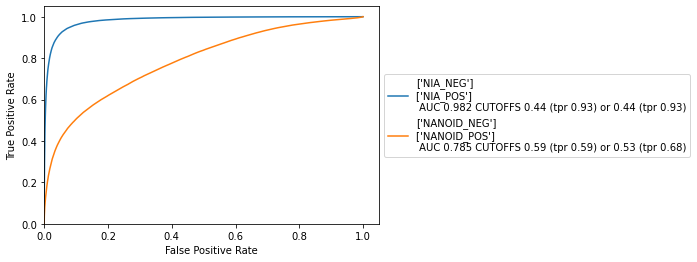

In [18]:
plot_roc([exp_readpred[NIA_POS], exp_readpred[NIA_NEG]])
plot_roc([exp_readpred[NANOID_POS], exp_readpred[NANOID_NEG]])

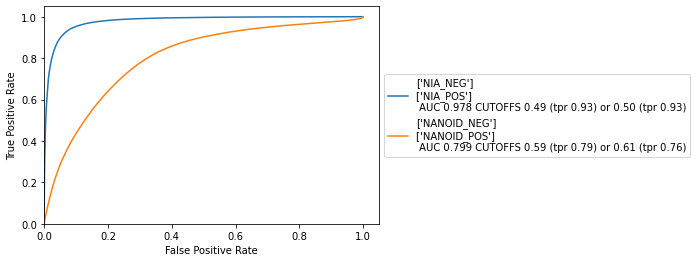

In [30]:
plot_roc([exp_readpred[NIA_POS], exp_readpred[NIA_NEG]])
plot_roc([exp_readpred[NANOID_POS], exp_readpred[NANOID_NEG]])